Loading trajectory data from energy_landscape_results/trajectory_data.pkl...
Successfully loaded trajectory data from energy_landscape_results/trajectory_data.pkl
Loading basis motif identities from basis_motif_identities/basis_motif_identities.pkl...
Successfully loaded basis motif identities
Creating enhanced expression heatmap...
Loading practice hours...
Loading practice hours from /home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx
Successfully loaded practice hours for 15 participants
Enhanced expression heatmap saved to: enhanced_visualizations/enhanced_expression_by_practice_experience.png


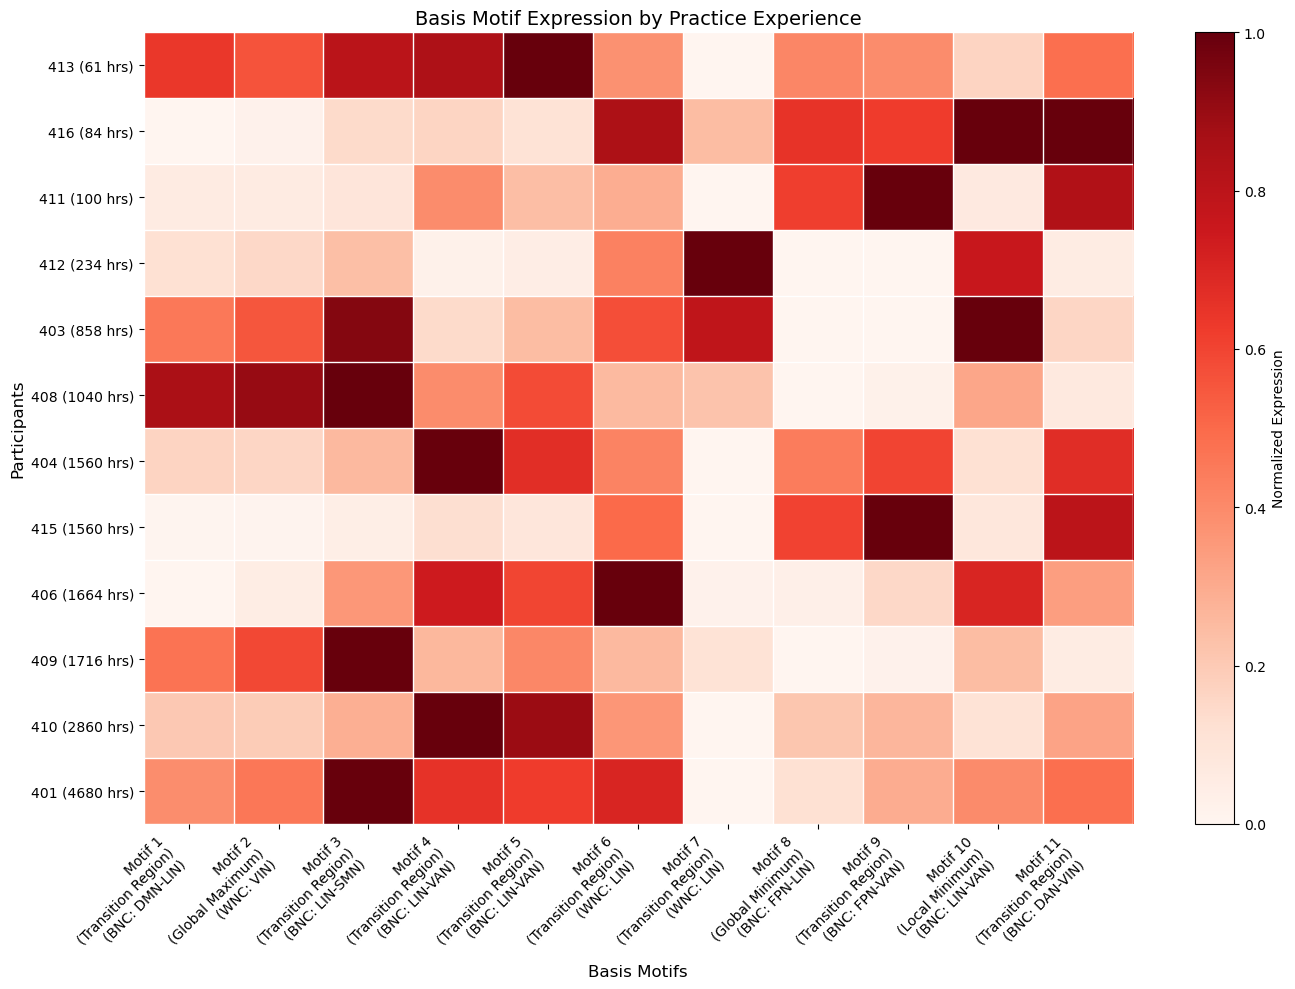

In [3]:
# Enhanced Heatmap - Basis Motif Expression, Topological Role, and (Primary) Network Indentity

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import re
import pandas as pd

# Create directory if it doesn't exist
output_dir = 'enhanced_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Network name abbreviation mapping
NETWORK_ABBREVIATIONS = {
    'Default': 'DMN',
    'Frontoparietal': 'FPN',
    'VentralAttention': 'VAN',
    'DorsalAttention': 'DAN',
    'Somatomotor': 'SMN',
    'Visual': 'VIN',
    'Limbic': 'LIN'
}

def abbreviate_network_identity(identity):
    """Convert network identity to abbreviated format"""
    if identity is None or identity == "Unknown" or not isinstance(identity, str):
        return "Unknown"
    
    # Replace "within_" with "WNC" and "between_" with "BNC"
    if identity.startswith('within_'):
        network = identity.replace('within_', '')
        # Apply network abbreviation
        if network in NETWORK_ABBREVIATIONS:
            return f"WNC: {NETWORK_ABBREVIATIONS[network]}"
        return f"WNC: {network}"
    
    elif identity.startswith('between_'):
        # Extract the two networks
        networks = identity.replace('between_', '').split('_')
        if len(networks) == 2:
            net1, net2 = networks
            # Apply network abbreviations
            if net1 in NETWORK_ABBREVIATIONS:
                net1 = NETWORK_ABBREVIATIONS[net1]
            if net2 in NETWORK_ABBREVIATIONS:
                net2 = NETWORK_ABBREVIATIONS[net2]
            return f"BNC: {net1}-{net2}"
        return f"BNC: {identity.replace('between_', '')}"
    
    return identity

def load_trajectory_data(file_path='energy_landscape_results/trajectory_data.pkl'):
    """Load trajectory data containing topological metrics"""
    print(f"Loading trajectory data from {file_path}...")
    
    # Try multiple possible file paths
    alt_paths = [
        file_path,
        'trajectory_data.pkl',
        os.path.join(os.getcwd(), 'energy_landscape_results/trajectory_data.pkl'),
        os.path.join(os.getcwd(), 'trajectory_data.pkl')
    ]
    
    for path in alt_paths:
        if os.path.exists(path):
            try:
                with open(path, 'rb') as f:
                    trajectory_data = pickle.load(f)
                print(f"Successfully loaded trajectory data from {path}")
                return trajectory_data
            except Exception as e:
                print(f"Error loading from {path}: {e}")
    
    print("Could not load trajectory data from any path")
    return None

def load_basis_identities(file_path='basis_motif_identities/basis_motif_identities.pkl'):
    """Load basis motif network identities"""
    print(f"Loading basis motif identities from {file_path}...")
    
    # Try multiple possible file paths
    alt_paths = [
        file_path,
        'basis_motif_identities.pkl',
        os.path.join(os.getcwd(), 'basis_motif_identities/basis_motif_identities.pkl'),
        os.path.join(os.getcwd(), 'basis_motif_identities.pkl')
    ]
    
    for path in alt_paths:
        if os.path.exists(path):
            try:
                with open(path, 'rb') as f:
                    basis_data = pickle.load(f)
                # Extract identities from the loaded data
                if isinstance(basis_data, dict):
                    if 'identities' in basis_data:
                        identities = basis_data['identities']
                    else:
                        # If the data structure is different, try to find identities
                        for key, value in basis_data.items():
                            if 'identity' in key.lower() or isinstance(value, dict):
                                identities = value
                                break
                        else:
                            identities = basis_data  # Just use the whole dict
                else:
                    identities = {}  # Empty dict if couldn't parse
                
                print(f"Successfully loaded basis motif identities")
                return identities
            except Exception as e:
                print(f"Error loading from {path}: {e}")
    
    print("Could not load basis identities from any path")
    return {}

def load_practice_hours():
    """Load practice hours from the specified Excel file"""
    print("Loading practice hours...")
    
    # Define potential file paths, with the correct file first
    file_paths = [
        '/home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx',
        'Participant Experience - TCOA 401-416.xlsx',
        os.path.join(os.getcwd(), 'Participant Experience - TCOA 401-416.xlsx'),
        'practice_hours.xlsx',
        'practice_hours.csv'
    ]
    
    practice_hours = {}
    
    for file_path in file_paths:
        if os.path.exists(file_path):
            try:
                print(f"Loading practice hours from {file_path}")
                
                if file_path.endswith('.xlsx'):
                    df = pd.read_excel(file_path)
                    # Look for ID and Experience columns
                    if 'ID' in df.columns and 'Experience' in df.columns:
                        for _, row in df.iterrows():
                            participant_id = str(int(row['ID']))
                            if len(participant_id) < 3:
                                participant_id = participant_id.zfill(3)
                            practice_hours[participant_id] = float(row['Experience'])
                        print(f"Successfully loaded practice hours for {len(practice_hours)} participants")
                        return practice_hours
                elif file_path.endswith('.csv'):
                    df = pd.read_csv(file_path)
                    if 'participant_id' in df.columns and 'practice_hours' in df.columns:
                        for _, row in df.iterrows():
                            participant_id = str(row['participant_id'])
                            practice_hours[participant_id] = float(row['practice_hours'])
                        print(f"Successfully loaded practice hours for {len(practice_hours)} participants")
                        return practice_hours
            except Exception as e:
                print(f"Error loading practice hours from {file_path}: {e}")
    
    # If we couldn't load practice hours from any file, create simulated data
    print("Warning: Could not load practice hours from any file. Using simulated data.")
    for i in range(1, 17):
        if i == 5:  # Skip 405
            continue
        participant_id = f"4{i:02d}"
        practice_hours[participant_id] = 500 + i*300
    
    return practice_hours

def plot_enhanced_expression_by_practice_hours(trajectory_data, basis_identities, 
                                             proximity_threshold=0.3, output_dir=output_dir):
    """
    Create an enhanced heatmap of basis motif expression by practice experience,
    including topological roles and network identities.
    """
    print("Creating enhanced expression heatmap...")
    
    # Extract required data
    topological_metrics = trajectory_data.get('topological_metrics', {})
    tcoa_results = trajectory_data.get('tcoa_results', {})
    basis_expression_by_participant = tcoa_results.get('basis_expression_by_participant', {})
    
    # Get practice hours using the dedicated function
    practice_hours = load_practice_hours()
    
    # Create ordered list of participants by practice hours
    participants = sorted([p for p in basis_expression_by_participant.keys() if p in practice_hours],
                          key=lambda p: practice_hours.get(p, 0))
    
    if not participants:
        print("Error: No overlap between expression data and practice hours")
        return
        
    clusters = sorted(topological_metrics.keys())
    
    # Build the expression matrix
    expression_matrix = np.zeros((len(participants), len(clusters)))
    for i, participant in enumerate(participants):
        for j, cluster in enumerate(clusters):
            expression_matrix[i, j] = basis_expression_by_participant[participant].get(cluster, 0)
    
    # Create combined labels with motif number, topological role, and network identity
    x_labels = []
    for cluster in clusters:
        # Get topological role
        topo_role = topological_metrics[cluster].get('topological_role', 'Unknown')
        
        # Get primary network identity (and abbreviate it)
        primary_identity = "Unknown"
        if cluster in basis_identities:
            if 'primary_identity' in basis_identities[cluster]:
                primary_identity = basis_identities[cluster]['primary_identity']
        
        abbr_identity = abbreviate_network_identity(primary_identity)
        
        # Create label with motif number, role, and identity
        label = f"Motif {cluster+1}\n({topo_role})\n({abbr_identity})"
        x_labels.append(label)
    
    # Prepare participant labels with practice hours
    y_labels = [f"{p} ({practice_hours.get(p, 0):.0f} hrs)" for p in participants]
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    cmap = plt.cm.Reds
    
    # Plot using imshow for better control
    im = plt.imshow(expression_matrix,
                   cmap=cmap,
                   aspect='auto',
                   extent=[-0.5, len(clusters) - 0.5,
                           len(participants) - 0.5, -0.5])
    
    # Set ticks and labels
    plt.xticks(np.arange(len(clusters)), x_labels, rotation=45, ha='right')
    plt.yticks(np.arange(len(participants)), y_labels)
    
    # Add grid lines
    ax = plt.gca()
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(-0.5, len(clusters)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(participants)), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Normalized Expression')
    
    plt.title('Basis Motif Expression by Practice Experience', fontsize=14)
    plt.xlabel('Basis Motifs', fontsize=12)
    plt.ylabel('Participants', fontsize=12)
    
    plt.tight_layout()
    fig_path = os.path.join(output_dir, 'enhanced_expression_by_practice_experience.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Enhanced expression heatmap saved to: {fig_path}")
    
    return plt.gcf()

# Execute the code
if __name__ == "__main__":
    # Load required data
    trajectory_data = load_trajectory_data()
    basis_identities = load_basis_identities()
    
    # Create the enhanced plot if data was loaded successfully
    if trajectory_data is not None:
        plot_enhanced_expression_by_practice_hours(trajectory_data, basis_identities)